In [493]:
import xarray as xr
import torch
import torch.nn.functional as F
import src.differentiable_fonc as DF
import numpy as np
import matplotlib.pyplot as plt

In [494]:
sound_speed_path = "/DATASET/eNATL/eNATL60_BLB002_sound_speed_regrid_0_1000m.nc"


In [495]:
ssp_da = xr.open_dataarray(sound_speed_path)
ssp_da

<xarray.DataArray 'celerity' (time: 365, z: 107, lat: 240, lon: 240)>
[2249568000 values with dtype=float64]
Coordinates:
  * lon      (lon) float64 -65.95 -65.9 -65.85 -65.8 ... -54.1 -54.05 -54.0
  * lat      (lat) float64 32.0 32.05 32.1 32.15 32.2 ... 43.8 43.85 43.9 43.95
  * z        (z) float64 0.4805 1.559 2.794 4.187 ... 968.4 985.3 1.002e+03
  * time     (time) datetime64[ns] 2009-07-01T12:00:00 ... 2010-06-30T12:00:00

In [496]:
restrict_data = 100
ssp_tens = torch.tensor(ssp_da.data[:restrict_data,:,:restrict_data,:restrict_data]).float()
coords = ssp_da[:restrict_data,:,:restrict_data,:restrict_data].coords
del ssp_da

In [497]:
depth_tens = torch.tensor(coords["z"].data)

# Functions

In [498]:
def explicit_ecs_3D(ssp: torch.tensor,
                    depth_tens: torch.tensor,
                    batch: bool = False,
                    tau = 10):
    
    if batch:
        ssp = ssp.unsqueeze(1).nan_to_num()  
    
    else:
        ssp = ssp.unsqueeze(0).unsqueeze(0).nan_to_num()       
        
    kernel = torch.tensor([-1.0, 1.0]).float().view(1,1,2,1,1).to(ssp.device)
    derivative = F.conv3d(ssp, kernel, padding=(0,0,0))

    sign = DF.differentiable_sign(derivative,tau)

    #sign = torch.sign(derivative) + F.tanh(tau * derivative) - F.tanh(tau * derivative).detach()
    #print("After torch.sign (sign):", sign.requires_grad, sign.grad_fn)


    sign_diff = F.conv3d(sign, kernel, padding=(1,0,0))
    #sign_change = F.tanh(10*F.relu(-sign_diff))
    sign_change = DF.differentiable_sign(F.relu(-sign_diff), tau)
    #sign_change[:,:,0,:,:] =  0 ##TODOm: check if this is correct


    for pattern in ([1, 0, 1], [1, -1, 0, 0]):  
        n = len(pattern)
        kernel_matrix = torch.eye(n)
        element_match = 0
        for i in range(n):
            kernel_element = kernel_matrix[i,:].view(1,1,n,1,1).to(ssp.device)
            element_match = element_match + (F.conv3d(sign, kernel_element, padding=(0,0,0)) - pattern[i])**2

        pattern_recognition = F.pad( element_match, (0, 0, 0, 0, 1, (sign_change.shape[2]- element_match.shape[2]) - 1),value=1.)    



        mask_discontinuity = 1 - F.relu(pattern_recognition+1) * F.relu(1-pattern_recognition)

        sign_change = sign_change * mask_discontinuity


    mask = F.relu(2 - torch.cumsum(sign_change, dim=2))

    depth_array_tens = depth_tens[:mask.shape[2]].view(1,-1,1,1).to(ssp.device).type(sign_change.dtype)
    depth_array_tens[0,0,0,0] = 0.  ##TODO the true first z value is equal to 48cm. It may have to be considered that way
    ecs_pred = (sign_change * mask ).squeeze(dim=1)
    ecs_pred = (ecs_pred * depth_array_tens).max(dim=1).values 
    
    
    if batch:
        ecs_pred = ecs_pred.squeeze(0)
        
    return ecs_pred



In [499]:
def differentiable_min_max_search(tensor, dim = 1, tau=10):
    grad = torch.diff(tensor,dim=dim)

    grad_sign = DF.differentiable_sign(grad,tau)

    inflection_points = torch.diff(grad_sign,dim=1)
    inflection_points = DF.differentiable_sign(inflection_points,tau)
    inflection_points = torch.abs(inflection_points)
    inflection_points = F.pad(inflection_points,pad=(0,0,0,0,1,1),value=1)

    return inflection_points


# Plot

In [500]:
ecs_from_explicit = explicit_ecs_3D(ssp_tens,depth_tens,batch=True)

In [501]:
indices_ecs_truth = np.searchsorted(depth_tens.detach().numpy(), ecs_from_explicit.detach().cpu().numpy())


In [502]:
max_ssp, max_ssp_idx = ssp_tens.nan_to_num(0).max(dim=1)
ecs_from_max = depth_tens[max_ssp_idx]

In [503]:
min_max_points = differentiable_min_max_search(ssp_tens,dim=1,tau=10)
min_max_points.shape

torch.Size([100, 107, 100, 100])

In [504]:
t,lat = 10,10

Text(0.47, 0.95, 'Sound Speed truth, t: 2009-07-11, lat: 32.5°')

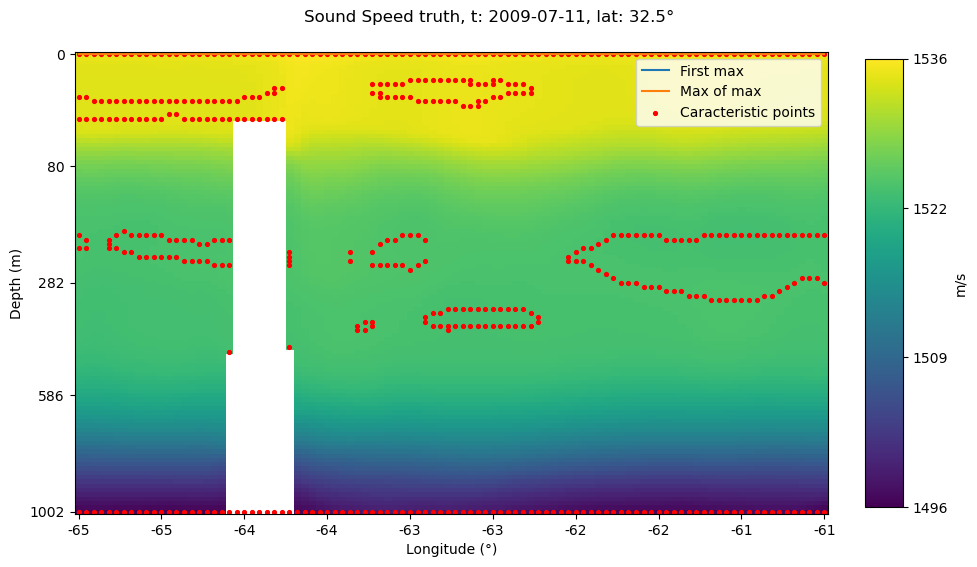

In [505]:
fig,ax = plt.subplots(1,1,figsize=(12,6))

im = ax.imshow(ssp_tens.detach().numpy()[t,:,lat,:], aspect = "auto")
#im = ax.imshow(min_max_ssp.detach().numpy()[t,:,lat,:], aspect = "auto")

ax.plot(indices_ecs_truth[t,lat,:], label = "First max")
ax.plot(max_ssp_idx[t,lat,:], label = "Max of max")

min_max = torch.nonzero(min_max_points[t,:,lat,:] == 1, as_tuple=False)
ax.scatter(min_max[:, 1].numpy(), min_max[:, 0].numpy(), color='red', marker='.', s=30, label='Caracteristic points')


y_tick_indices = np.linspace(0, len(depth_tens) - 1, 5, dtype=int)
y_tick_values = depth_tens[y_tick_indices].detach().numpy()

x_tick_indices = np.linspace(0, len(coords["lon"].data) - 1, 10, dtype=int)
x_tick_values = coords["lon"].data[x_tick_indices]

ax.set_yticks(y_tick_indices)
ax.set_yticklabels([str(y) for y in y_tick_values.astype((np.int16))])

ax.set_xticks(x_tick_indices)
ax.set_xticklabels([str(y) for y in x_tick_values.astype((np.int16))])
ax.grid(False)

ax.set_xlabel("Longitude (°)")
ax.set_ylabel("Depth (m)")
ax.legend()


cbar = fig.colorbar(im, shrink = .97, aspect=12, pad = 0.04)
cbar.set_label("m/s")

min_val, max_val = im.get_clim()
ticks = np.linspace(min_val, max_val, 4)
cbar.set_ticks(ticks)
cbar.set_ticklabels([f'{tick:.0f}' for tick in ticks])

fig.suptitle(f"Sound Speed truth, t: {coords['time'].data[t].astype('datetime64[D]')}, lat: {np.round(coords['lat'].data[lat],2)}°",x=0.47, y = 0.95)



In [506]:
min_max = torch.nonzero(min_max_points[t,:,lat,lon] == 1, as_tuple=False)
min_max

tensor([[  0],
        [ 42],
        [ 54],
        [106]])

In [507]:
ssp_tens.detach().numpy()[t,:,lat,lon][min_max]

array([[1534.7493],
       [1523.868 ],
       [1524.151 ],
       [1496.1881]], dtype=float32)

In [508]:
fig,axs = plt.subplots(1,2,figsize=(16,8))

axs[0].plot(ssp_tens[t,:,lat,lon].detach().numpy(),depth_tens.detach().numpy())
axs[1].plot(min_max_points[t,:,lat,lon].detach().numpy(), depth_tens.detach().numpy())

for ax in axs:
    ax.invert_yaxis()

Text(0.5, 0.94, 'Sound Speed truth, t: 2009-07-11, lat: 32.5°')

<Figure size 1600x800 with 2 Axes>